# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.model_selection import ExpandingWindowSplitter

#import functions from the functions notebook
%run functions.ipynb
import import_ipynb
import functions

In [2]:
np.random.seed(42)

In [3]:
contributions = pd.read_csv('./data/canada_contribution_data.csv', 
                            index_col = 'fiscal/election_date', 
                            parse_dates =True )


C:\Users\wtlem\AppData\Local\Temp\ipykernel_11560\3204846671.py:1: DtypeWarning: Columns (4,6,8,9,10,11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  contributions = pd.read_csv('./data/canada_contribution_data.csv',


In [4]:
contributions.head(2)

,political_entity,recipient,political_party_of_recipient,electoral_district,electoral_event,contributor_type,contributor_name,contributor_city,contributor_province,contributor_postal_code,contribution_received_date,monetary_amount,non_monetary_amount,leadership_contestant,total_contribution,election_year,year
fiscal/election_date,,,,,,,,,,,,,,,,,
1993-10-25,Candidate,"Langlois, Charles",conservative,Manicouagan,35th General Election,Registered parties,Ass. Conservatrice,NaN,NaN,NaN,NaN,5000.0,0.0,NaN,5000.0,1,1993
1993-10-25,Candidate,"Gray, Darryl L.",conservative,Bonaventure--Îles-de-la-Madeleine,35th General Election,Individuals,Jules Corriveau,NaN,NaN,NaN,NaN,100.0,0.0,NaN,100.0,1,1993


In [5]:
contributions.tail(2)

,political_entity,recipient,political_party_of_recipient,electoral_district,electoral_event,contributor_type,contributor_name,contributor_city,contributor_province,contributor_postal_code,contribution_received_date,monetary_amount,non_monetary_amount,leadership_contestant,total_contribution,election_year,year
fiscal/election_date,,,,,,,,,,,,,,,,,
2024-03-04,Candidates,"Rock, Robert",liberal,Durham,"March 4, 2024, By-election",Individuals,unknown,unknown,unknown,unknown,unknown,0.0,0.0,none,0.0,0,2024
2024-03-04,Candidates,"Rock, Robert",liberal,Durham,"March 4, 2024, By-election",Individuals,Contributions of $200 or less/contributions de...,unknown,unknown,unknown,unknown,10.0,0.0,none,10.0,0,2024


In [6]:
party_list = ['liberal', 'conservative', 'ndp', 'bloc_québécois']


# Baseline Model

In [7]:
#create list of election years
election_years = [1993,1997,2000, 2004, 2006, 2008, 2011, 2015, 2019, 2021]

## Liberal

In [8]:
party = 'liberal'

#get train test split for 4 years
X_train, y_train, X_test, y_test = get_tts(data = contributions, 
        election_years = election_years, 
       party = party,
       train_end = 2019, 
       test_end = 2023,
       lags = 5)

In [9]:
#instantiate naive forecaster, fit and get predictions
liberal_base_model = NaiveForecaster(strategy = 'mean')
liberal_base_model.fit(y_train)
liberal_base_preds = liberal_base_model.predict(y_test.index)

C:\Users\wtlem\anaconda3\envs\sktime_env\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


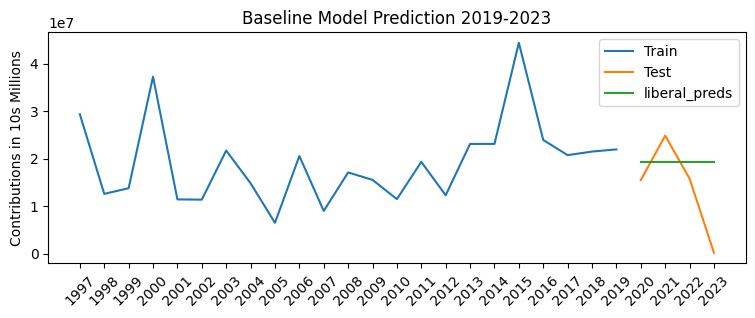

In [10]:
#plot baseline forecast
plt.figure(figsize = (9, 3))
plt.plot(y_train, label = 'Train')
plt.plot(y_test, label = 'Test')
plt.plot(y_test.index, liberal_base_preds, label = 'liberal_preds')
plt.title('Baseline Model Prediction 2019-2023')
plt.ylabel('Contributions in 10''s Millions')
plt.xticks(range(1997, 2024), rotation = 45)
plt.legend();

In [11]:
#get base metrics
liberal_base_rmse = round(root_mean_squared_error(y_test, liberal_base_preds),0)
liberal_base_mae = round(mean_absolute_error(y_test, liberal_base_preds),0)

In [12]:
#display base metrics 
print(f'Liberal Baseline Model')
print(f'RMSE: {liberal_base_rmse}')
print(f'MAE: {liberal_base_mae}')

Liberal Baseline Model
RMSE: 10271735.0
MAE: 7979432.0


## Conservative 

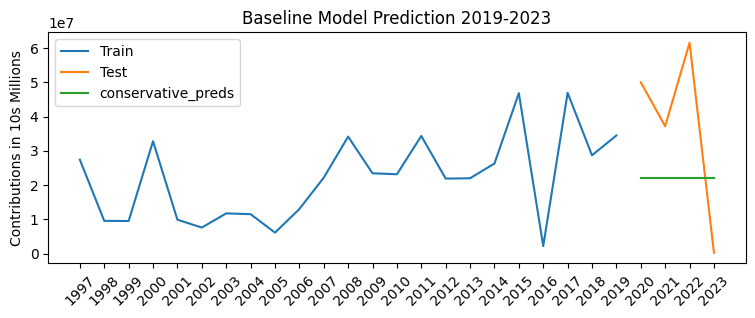

In [13]:
party = 'conservative'

#get train test split for 4 years
X_train, y_train, X_test, y_test = get_tts(data = contributions, 
        election_years = election_years, 
       party = party,
       train_end = 2019, 
       test_end = 2023,
       lags = 5)

#instantiate naive forecaster, fit and get predictions
conservative_base_model = NaiveForecaster(strategy = 'mean')
conservative_base_model.fit(y_train)
conservative_base_preds = conservative_base_model.predict(y_test.index)

#plot baseline forecast
plt.figure(figsize = (9, 3))
plt.plot(y_train, label = 'Train')
plt.plot(y_test, label = 'Test')
plt.plot(y_test.index, conservative_base_preds, label = 'conservative_preds')
plt.title('Baseline Model Prediction 2019-2023')
plt.ylabel('Contributions in 10''s Millions')
plt.xticks(range(1997, 2024), rotation = 45)
plt.legend();

In [14]:
#get base metrics
conservative_base_rmse = round(root_mean_squared_error(y_test, conservative_base_preds),0)
conservative_base_mae = round(mean_absolute_error(y_test, conservative_base_preds),0)

#display base metrics 
print(f'Liberal Baseline Model')
print(f'RMSE: {conservative_base_rmse}')
print(f'MAE: {conservative_base_mae}')

Liberal Baseline Model
RMSE: 27658120.0
MAE: 26156665.0


## NDP

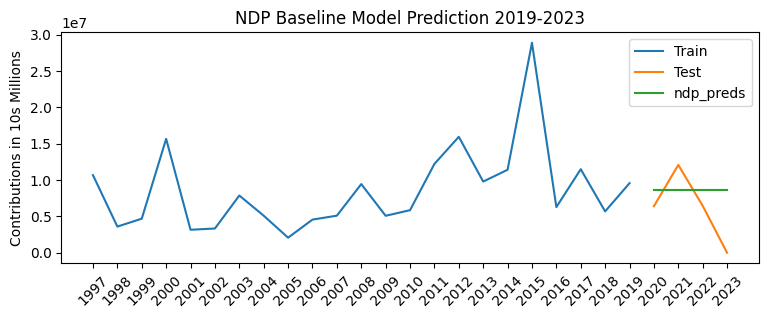

In [15]:
party = 'ndp'

#get train test split for 4 years
X_train, y_train, X_test, y_test = get_tts(data = contributions, 
        election_years = election_years, 
       party = party,
       train_end = 2019, 
       test_end = 2023,
       lags = 5)

#instantiate naive forecaster, fit and get predictions
ndp_base_model = NaiveForecaster(strategy = 'mean')
ndp_base_model.fit(y_train)
ndp_base_preds = ndp_base_model.predict(y_test.index)

#plot baseline forecast
plt.figure(figsize = (9, 3))
plt.plot(y_train, label = 'Train')
plt.plot(y_test, label = 'Test')
plt.plot(y_test.index, ndp_base_preds, label = 'ndp_preds')
plt.title('NDP Baseline Model Prediction 2019-2023')
plt.ylabel('Contributions in 10''s Millions')
plt.xticks(range(1997, 2024), rotation = 45)
plt.legend();

In [16]:
#get base metrics
ndp_base_rmse = round(root_mean_squared_error(y_test, ndp_base_preds),0)
ndp_base_mae = round(mean_absolute_error(y_test, ndp_base_preds),0)

#display base metrics 
print(f'NDP Baseline Model')
print(f'RMSE: {ndp_base_rmse}')
print(f'MAE: {ndp_base_mae}')

NDP Baseline Model
RMSE: 4883017.0
MAE: 4101601.0


## Bloc Québécois

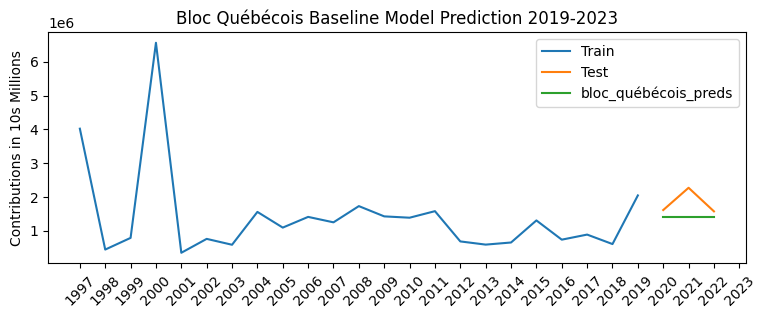

In [17]:
party = 'bloc_québécois'

#get train test split for 4 years
X_train, y_train, X_test, y_test = get_tts(data = contributions, 
        election_years = election_years, 
       party = party,
       train_end = 2019, 
       test_end = 2023,
       lags = 5)

#instantiate naive forecaster, fit and get predictions
bloc_québécois_base_model = NaiveForecaster(strategy = 'mean')
bloc_québécois_base_model.fit(y_train)
bloc_québécois_base_preds = bloc_québécois_base_model.predict(y_test.index)

#plot baseline forecast
plt.figure(figsize = (9, 3))
plt.plot(y_train, label = 'Train')
plt.plot(y_test, label = 'Test')
plt.plot(y_test.index, bloc_québécois_base_preds, label = 'bloc_québécois_preds')
plt.title('Bloc Québécois Baseline Model Prediction 2019-2023')
plt.ylabel('Contributions in 10''s Millions')
plt.xticks(range(1997, 2024), rotation = 45)
plt.legend();

In [18]:
#get base metrics
bloc_québécois_base_rmse = round(root_mean_squared_error(y_test, bloc_québécois_base_preds),0)
bloc_québécois_base_mae = round(mean_absolute_error(y_test, bloc_québécois_base_preds),0)

#display base metrics 
print(f'Bloc Québécois Baseline Model')
print(f'RMSE: {bloc_québécois_base_rmse}')
print(f'MAE: {bloc_québécois_base_mae}')

Bloc Québécois Baseline Model
RMSE: 518645.0
MAE: 408259.0


# Linear Model

In [19]:
#create a dataframe to store modeling results
model_res = pd.DataFrame()

## Liberal(l1)

In [20]:
X_train, y_train, X_test, y_test = get_tts(data = contributions, 
        election_years = election_years, 
       party = 'liberal',
       train_end = 2019, 
       test_end = 2023,
       lags = 5)

In [21]:
model_res = pd.concat([model_res, 
                       lr_results(X_train, y_train, X_test, y_test,
                                  input_df = model_res,
                                  party = 'liberal',
                                 model_name = 'L1')]
                                    )
#get predictions 
l1_preds = extract_preds(model_res, 'L1')

model_res

,model_name,model,party,scaler,rmse,mae,preds
0,L1,lr,liberal,None,5941013.0,3911651.0,"[14496039.580529226, 27999067.081884578, 15895..."


In [22]:
y_train.shape,  X_train.shape

((23,), (23, 6))

In [23]:
y_test.shape, X_test.shape

((4,), (4, 6))

In [24]:
l1_preds.shape

(4,)

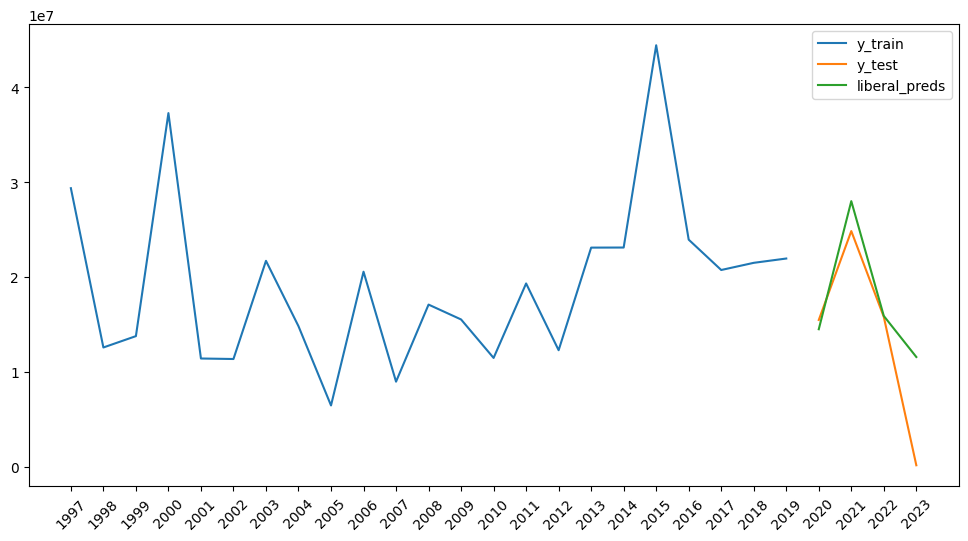

In [25]:
plt.figure(figsize = (12, 6))
plt.plot(y_train, label = 'y_train')
plt.plot(y_test, label = 'y_test')
plt.plot(y_test.index, l1_preds, label = 'liberal_preds')
plt.xticks(range(1997, 2024), rotation = 45)
plt.legend();

## Liberal Scaled(L2)

The above model does not fit well for the upper and lower ends so I will experiment with scaling the y variables to see if that improves prediction. 

In [26]:
X_train, y_train, X_test, y_test = get_tts(data = contributions, 
        election_years = election_years, 
       party = 'liberal',
       scaler = 'log',                                    
       train_end = 2019, 
       test_end = 2023,
       lags = 5)

In [27]:
model_res = pd.concat([model_res, 
                       lr_results(X_train, y_train, X_test, y_test,
                                  input_df = model_res,
                                  party = 'liberal',
                                 scaler = 'log',
                                 model_name = 'L2')]
                            )
#get predictions 
l2_preds = extract_preds(model_res, 'L2')

model_res.drop(columns = 'preds')

,model_name,model,party,scaler,rmse,mae
0,L1,lr,liberal,None,5941013.0,3911651.0
0,L2,lr,liberal,log,6547936.0,4090028.0


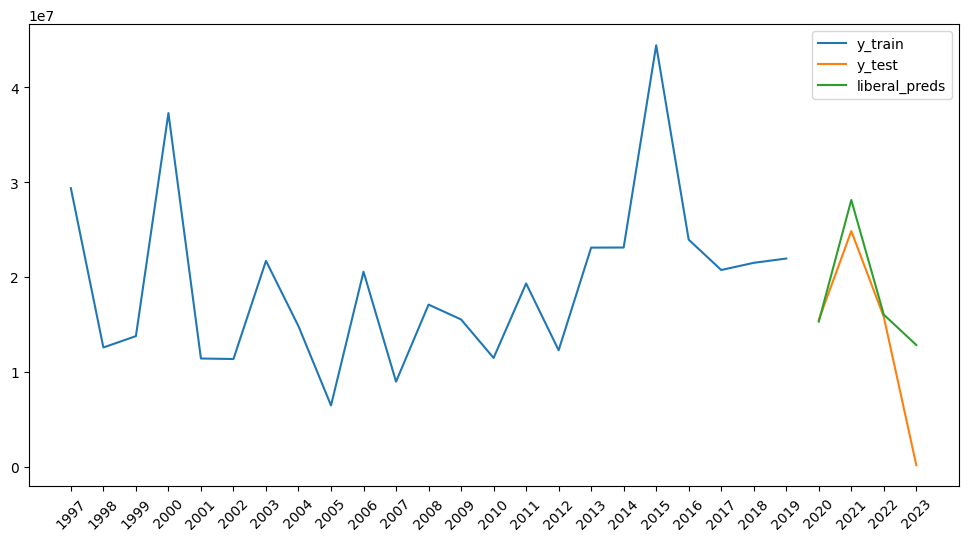

In [28]:
plt.figure(figsize = (12, 6))
plt.plot(np.exp(y_train), label = 'y_train')
plt.plot(np.exp(y_test), label = 'y_test')
plt.plot(y_test.index, l2_preds, label = 'liberal_preds')
plt.xticks(range(1997, 2024), rotation = 45)
plt.legend();

## Conservative(C1)

In [29]:
X_train, y_train, X_test, y_test = get_tts(data = contributions, 
        election_years = election_years, 
       party = 'conservative',
       train_end = 2019, 
       test_end = 2023,
       lags = 5)

model_res = pd.concat([model_res, 
                       lr_results(X_train, y_train, X_test, y_test, 
                                  input_df = model_res, 
                                  party = 'conservative',
                                 model_name = 'C1')]
                                    )
c1_preds = extract_preds(model_res, 'C1')
model_res.drop(columns = 'preds')

,model_name,model,party,scaler,rmse,mae
0,L1,lr,liberal,None,5941013.0,3911651.0
0,L2,lr,liberal,log,6547936.0,4090028.0
0,C1,lr,conservative,None,24354536.0,21323675.0


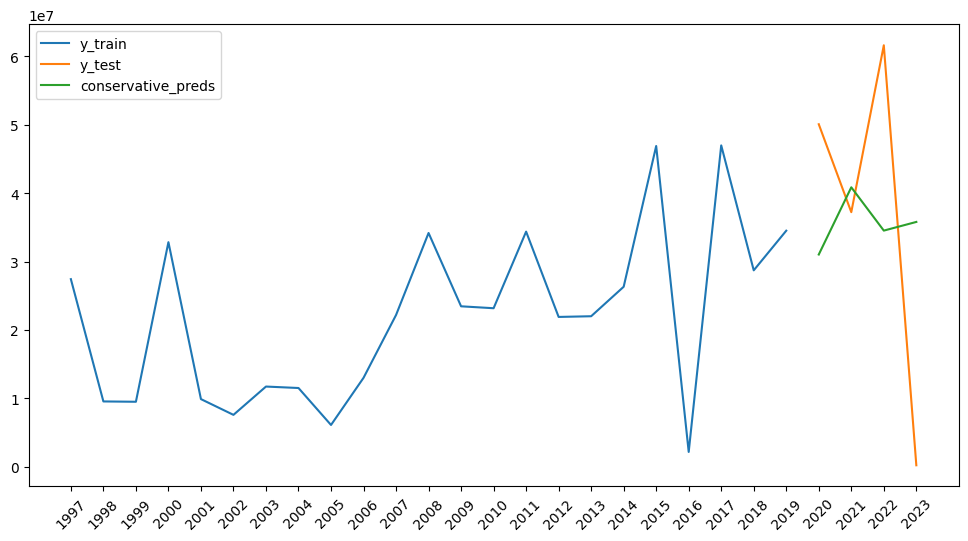

In [30]:
plt.figure(figsize = (12, 6))
plt.plot(y_train, label = 'y_train')
plt.plot(y_test, label = 'y_test')
plt.plot(y_test.index, c1_preds, label = 'conservative_preds')
plt.xticks(range(1997, 2024), rotation = 45)
plt.legend();

## Scaled Conservative(C2)

In [31]:
X_train, y_train, X_test, y_test = get_tts(data = contributions, 
        election_years = election_years, 
       party = 'conservative',
       train_end = 2019, 
       test_end = 2023,
       lags = 5,
        scaler = 'log')

model_res = pd.concat([model_res, 
                       lr_results(X_train, y_train, X_test, y_test, 
                                  input_df = model_res, 
                                  party = 'conservative',
                                 model_name = 'C2',
                                 scaler = 'log')]
                                    )
c2_preds = extract_preds(model_res, 'C2')
model_res.drop(columns = 'preds')

,model_name,model,party,scaler,rmse,mae
0,L1,lr,liberal,None,5941013.0,3911651.0
0,L2,lr,liberal,log,6547936.0,4090028.0
0,C1,lr,conservative,None,24354536.0,21323675.0
0,C2,lr,conservative,log,29611724.0,24809677.0


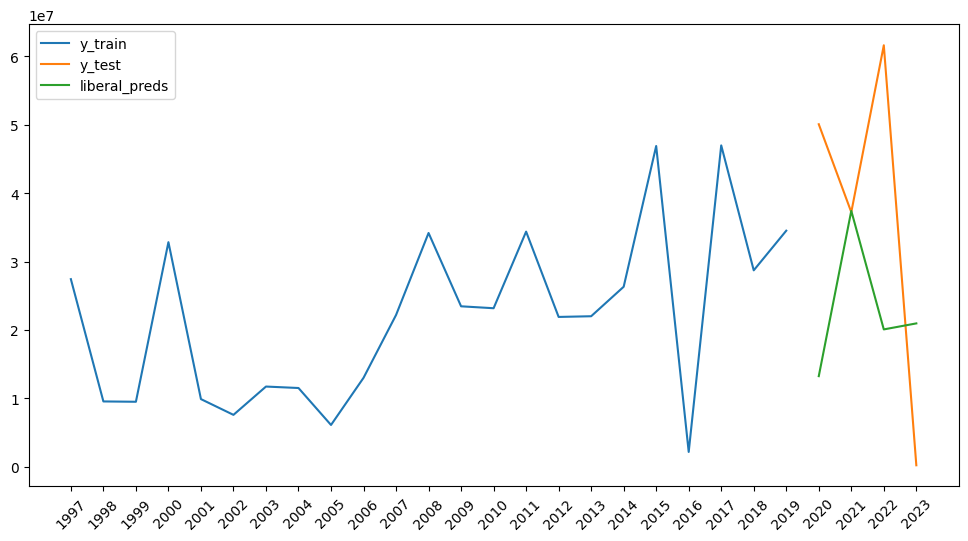

In [32]:
plt.figure(figsize = (12, 6))
plt.plot(np.exp(y_train), label = 'y_train')
plt.plot(np.exp(y_test), label = 'y_test')
plt.plot(y_test.index, c2_preds, label = 'liberal_preds')
plt.xticks(range(1997, 2024), rotation = 45)
plt.legend();

## NDP(N1)

In [33]:
X_train, y_train, X_test, y_test = get_tts(data = contributions, 
        election_years = election_years, 
       party = 'ndp',
       train_end = 2019, 
       test_end = 2023,
       lags = 5)

model_res = pd.concat([model_res, 
                       lr_results(X_train, y_train, X_test, y_test, 
                                  input_df = model_res, 
                                  party = 'ndp',
                                 model_name = 'N1')]
                                    )
n1_preds = extract_preds(model_res, 'N1')
model_res.drop(columns = 'preds')

,model_name,model,party,scaler,rmse,mae
0,L1,lr,liberal,None,5941013.0,3911651.0
0,L2,lr,liberal,log,6547936.0,4090028.0
0,C1,lr,conservative,None,24354536.0,21323675.0
0,C2,lr,conservative,log,29611724.0,24809677.0
0,N1,lr,ndp,None,2885209.0,1795680.0


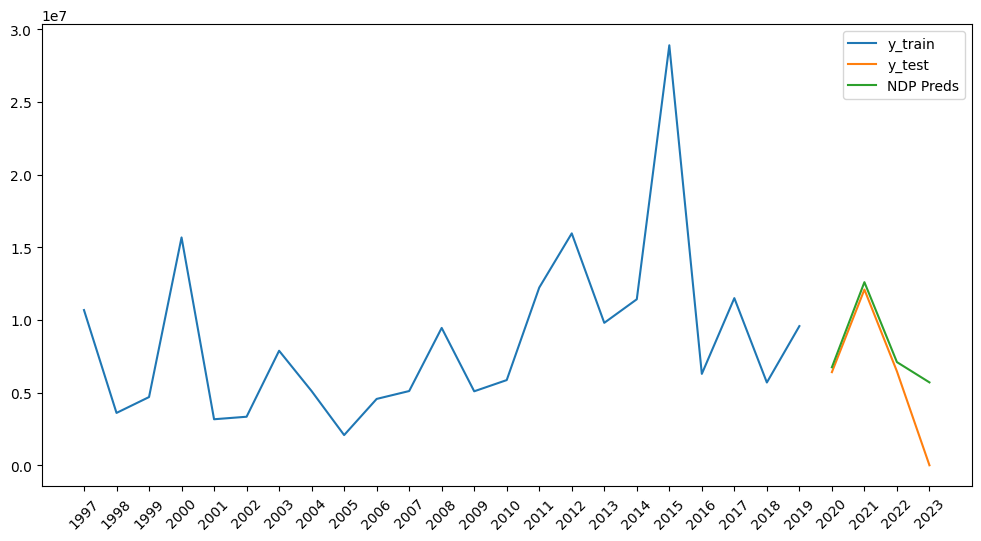

In [34]:
plt.figure(figsize = (12, 6))
plt.plot(y_train, label = 'y_train')
plt.plot(y_test, label = 'y_test')
plt.plot(y_test.index, n1_preds, label = 'NDP Preds')
plt.xticks(range(1997, 2024), rotation = 45)
plt.legend();

## Scaled NDP(N2

In [35]:
X_train, y_train, X_test, y_test = get_tts(data = contributions, 
        election_years = election_years, 
       party = 'ndp',
       train_end = 2019, 
       test_end = 2023,
       lags = 5,
        scaler = 'log')

model_res = pd.concat([model_res, 
                       lr_results(X_train, y_train, X_test, y_test, 
                                  input_df = model_res, 
                                  party = 'ndp',
                                 model_name = 'N2',
                                 scaler = 'log')]
                                    )
n2_preds = extract_preds(model_res, 'N2')
model_res.drop(columns = 'preds')

,model_name,model,party,scaler,rmse,mae
0,L1,lr,liberal,None,5941013.0,3911651.0
0,L2,lr,liberal,log,6547936.0,4090028.0
0,C1,lr,conservative,None,24354536.0,21323675.0
0,C2,lr,conservative,log,29611724.0,24809677.0
0,N1,lr,ndp,None,2885209.0,1795680.0
0,N2,lr,ndp,log,3045706.0,1921515.0


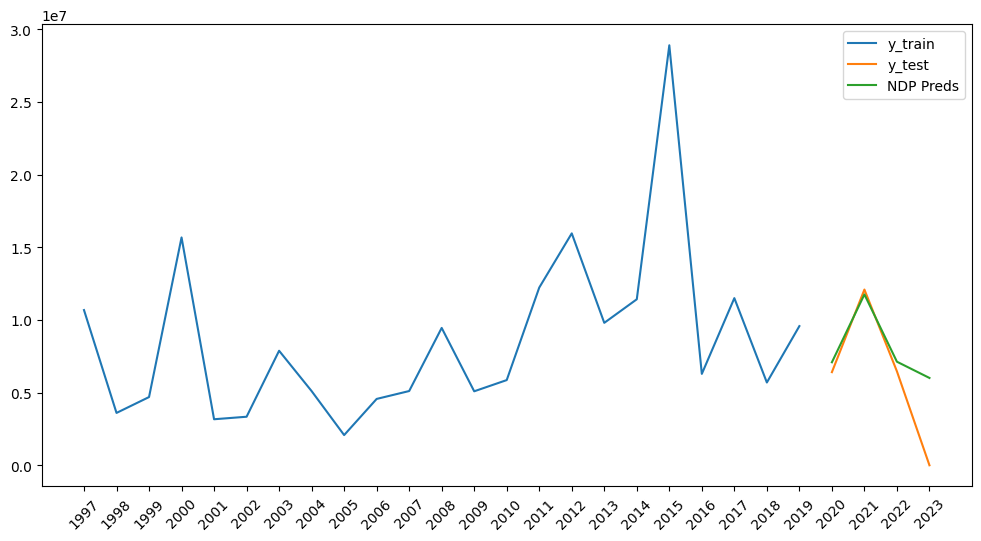

In [36]:
plt.figure(figsize = (12, 6))
plt.plot(np.exp(y_train), label = 'y_train')
plt.plot(np.exp(y_test), label = 'y_test')
plt.plot(y_test.index, n2_preds, label = 'NDP Preds')
plt.xticks(range(1997, 2024), rotation = 45)
plt.legend();

## Bloc(B1)

In [37]:
X_train, y_train, X_test, y_test = get_tts(data = contributions, 
        election_years = election_years, 
       party = 'bloc_québécois',
       train_end = 2019, 
       test_end = 2023,
       lags = 5)

model_res = pd.concat([model_res, 
                       lr_results(X_train, y_train, X_test, y_test, 
                                  input_df = model_res, 
                                  party = 'bloc_québécois',
                                 model_name = 'B1')]
                                    )
b1_preds = extract_preds(model_res, 'B1')
model_res.drop(columns = 'preds')

,model_name,model,party,scaler,rmse,mae
0,L1,lr,liberal,None,5941013.0,3911651.0
0,L2,lr,liberal,log,6547936.0,4090028.0
0,C1,lr,conservative,None,24354536.0,21323675.0
0,C2,lr,conservative,log,29611724.0,24809677.0
0,N1,lr,ndp,None,2885209.0,1795680.0
0,N2,lr,ndp,log,3045706.0,1921515.0
0,B1,lr,bloc_québécois,None,969905.0,894225.0


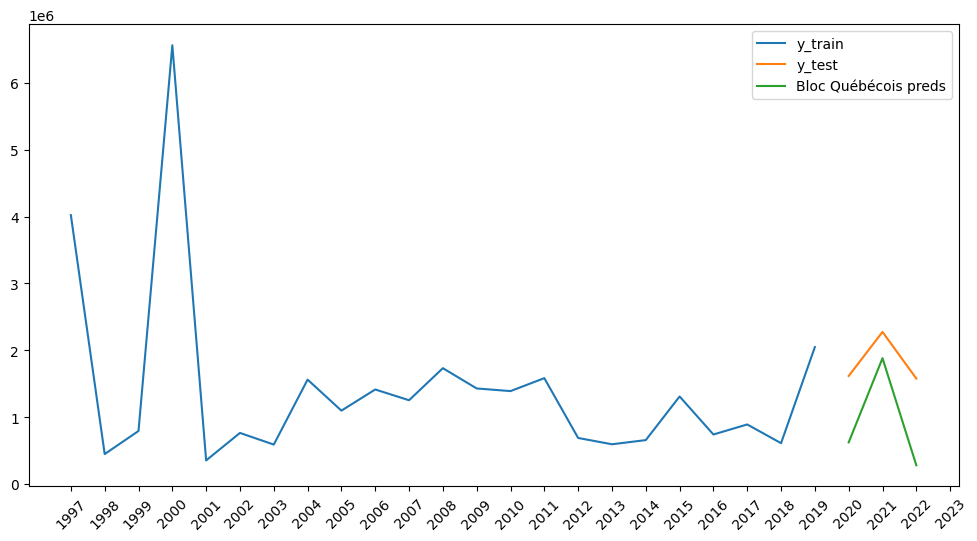

In [38]:
plt.figure(figsize = (12, 6))
plt.plot(y_train, label = 'y_train')
plt.plot(y_test, label = 'y_test')
plt.plot(y_test.index, b1_preds, label = 'Bloc Québécois preds')
plt.xticks(range(1997, 2024), rotation = 45)
plt.legend();

## Bloc Scaled(B2)

In [39]:
X_train, y_train, X_test, y_test = get_tts(data = contributions, 
        election_years = election_years, 
       party = 'bloc_québécois',
       train_end = 2019, 
       test_end = 2023,
       lags = 5,
        scaler = 'log')

model_res = pd.concat([model_res, 
                       lr_results(X_train, y_train, X_test, y_test, 
                                  input_df = model_res, 
                                  party = 'bloc_québécois',
                                 model_name = 'B2',
                                 scaler = 'log')]
                                    )
b2_preds = extract_preds(model_res, 'B2')
model_res.drop(columns = 'preds')

,model_name,model,party,scaler,rmse,mae
0,L1,lr,liberal,None,5941013.0,3911651.0
0,L2,lr,liberal,log,6547936.0,4090028.0
0,C1,lr,conservative,None,24354536.0,21323675.0
0,C2,lr,conservative,log,29611724.0,24809677.0
0,N1,lr,ndp,None,2885209.0,1795680.0
0,N2,lr,ndp,log,3045706.0,1921515.0
0,B1,lr,bloc_québécois,None,969905.0,894225.0
0,B2,lr,bloc_québécois,log,641509.0,550668.0


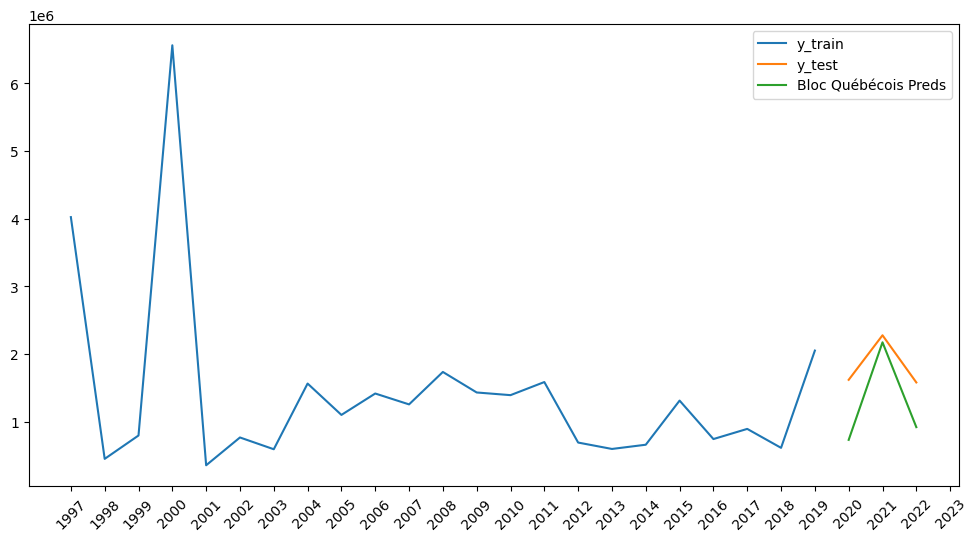

In [40]:
plt.figure(figsize = (12, 6))
plt.plot(np.exp(y_train), label = 'y_train')
plt.plot(np.exp(y_test), label = 'y_test')
plt.plot(y_test.index, b2_preds, label = 'Bloc Québécois Preds')
plt.xticks(range(1997, 2024), rotation = 45)
plt.legend();

# ARIMA Models

## Liberal(L3)

In [41]:
party = 'liberal'
model_name = 'L3'

#liberal Train test Split 
X_train, y_train, X_test, y_test = get_tts(data = contributions, 
        election_years = election_years, 
       party = party,
       train_end = 2019, 
       test_end = 2023,
       lags = 0)

In [42]:

model_res = pd.concat([model_res, 
                       arima_results(X_train, y_train, X_test, y_test, 
                                     party = party, 
                                     fh = [1,2,3,4], 
                                     model_name = model_name,
                                    param_grid =  
                                     {'order': [(1,0,0), (5,0,0), (7,0,0),
                                    (1,1,0),(3,1,0),(5,1,0),
                                    (1,1,1), (3,1,1), (5,1,1), (7,1,1)],
                                      
                                    'trend': [None, "t","ct"]}
                                     )])
l3_preds = extract_preds(model_res, model_name)
model_res.drop(columns = 'preds')

C:\Users\wtlem\anaconda3\envs\sktime_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\wtlem\anaconda3\envs\sktime_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\wtlem\anaconda3\envs\sktime_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wtlem\anaconda3\envs\sktime_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index 

,model_name,model,party,scaler,rmse,mae
0,L1,lr,liberal,None,5941013.0,3911651.0
0,L2,lr,liberal,log,6547936.0,4090028.0
0,C1,lr,conservative,None,24354536.0,21323675.0
0,C2,lr,conservative,log,29611724.0,24809677.0
0,N1,lr,ndp,None,2885209.0,1795680.0
0,N2,lr,ndp,log,3045706.0,1921515.0
0,B1,lr,bloc_québécois,None,969905.0,894225.0
0,B2,lr,bloc_québécois,log,641509.0,550668.0
0,L3,arima,liberal,None,26531268.0,22931040.0


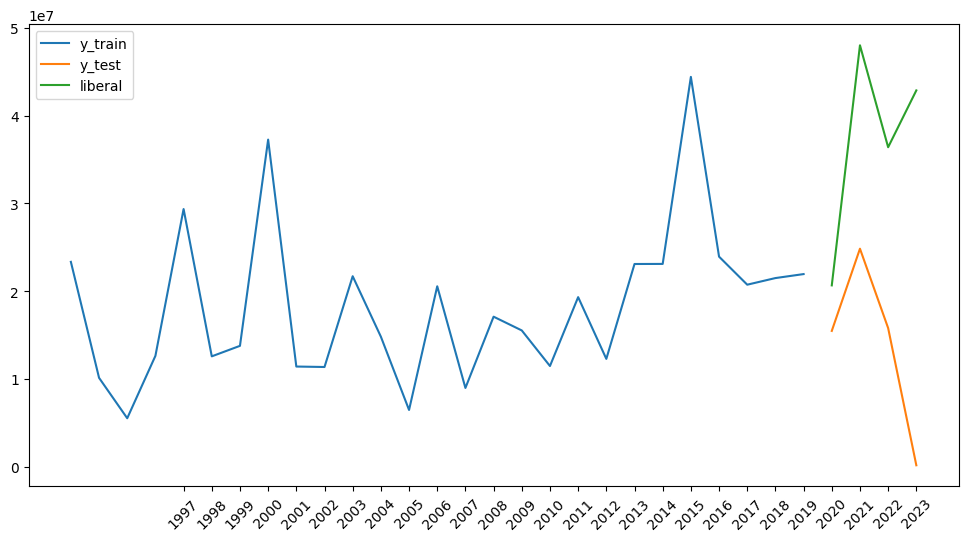

In [43]:
plt.figure(figsize = (12, 6))
plt.plot(y_train, label = 'y_train')
plt.plot(y_test, label = 'y_test')
plt.plot(y_test.index, l3_preds, label = party)
plt.xticks(range(1997, 2024), rotation = 45)
plt.legend();

## Conservative(C3)

In [44]:
party = 'conservative'
model_name = 'C3'

#Train test Split 
X_train, y_train, X_test, y_test = get_tts(data = contributions, 
        election_years = election_years, 
       party = party,
       train_end = 2019, 
       test_end = 2023,
       lags = 0)

In [45]:

model_res = pd.concat([model_res, 
                       arima_results(X_train, y_train, X_test, y_test, 
                                     party = party, 
                                     fh = [1,2,3,4], 
                                     model_name = model_name,
                                    param_grid =  
                                     {'order': [(1,0,0), (5,0,0), (7,0,0),
                                    (1,1,0),(3,1,0),(5,1,0),
                                    (1,1,1), (3,1,1), (5,1,1), (7,1,1)],
                                      
                                    'trend': [None, "t","ct"]}
                                     )])
c3_preds = extract_preds(model_res, model_name)
model_res.drop(columns = 'preds')

C:\Users\wtlem\anaconda3\envs\sktime_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\wtlem\anaconda3\envs\sktime_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\wtlem\anaconda3\envs\sktime_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\wtlem\anaconda3\envs\sktime_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Va

,model_name,model,party,scaler,rmse,mae
0,L1,lr,liberal,None,5941013.0,3911651.0
0,L2,lr,liberal,log,6547936.0,4090028.0
0,C1,lr,conservative,None,24354536.0,21323675.0
0,C2,lr,conservative,log,29611724.0,24809677.0
0,N1,lr,ndp,None,2885209.0,1795680.0
0,N2,lr,ndp,log,3045706.0,1921515.0
0,B1,lr,bloc_québécois,None,969905.0,894225.0
0,B2,lr,bloc_québécois,log,641509.0,550668.0
0,L3,arima,liberal,None,26531268.0,22931040.0
0,C3,arima,conservative,None,33402313.0,25916453.0


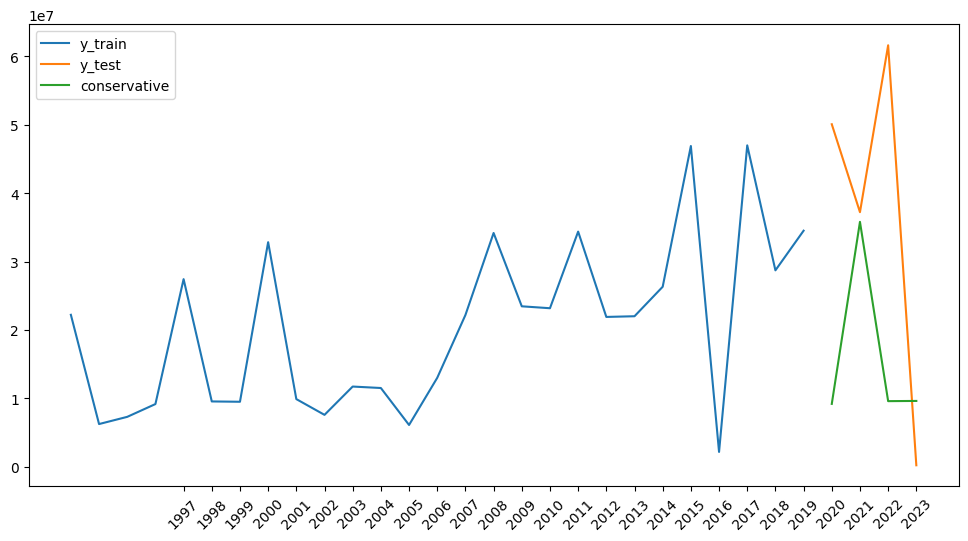

In [46]:
plt.figure(figsize = (12, 6))
plt.plot(y_train, label = 'y_train')
plt.plot(y_test, label = 'y_test')
plt.plot(y_test.index, c3_preds, label = party)
plt.xticks(range(1997, 2024), rotation = 45)
plt.legend();

## NDP(N3)

In [47]:
party = 'ndp'
model_name = 'N3'

#Train test Split 
X_train, y_train, X_test, y_test = get_tts(data = contributions, 
        election_years = election_years, 
       party = party,
       train_end = 2019, 
       test_end = 2023,
       lags = 0)

In [48]:

model_res = pd.concat([model_res, 
                       arima_results(X_train, y_train, X_test, y_test, 
                                     party = party, 
                                     fh = [1,2,3,4], 
                                     model_name = model_name)]
                                    )
n3_preds = extract_preds(model_res, model_name)
model_res.drop(columns = 'preds')

C:\Users\wtlem\anaconda3\envs\sktime_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\wtlem\anaconda3\envs\sktime_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\wtlem\anaconda3\envs\sktime_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\wtlem\anaconda3\envs\sktime_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Va

,model_name,model,party,scaler,rmse,mae
0,L1,lr,liberal,None,5941013.0,3911651.0
0,L2,lr,liberal,log,6547936.0,4090028.0
0,C1,lr,conservative,None,24354536.0,21323675.0
0,C2,lr,conservative,log,29611724.0,24809677.0
0,N1,lr,ndp,None,2885209.0,1795680.0
0,N2,lr,ndp,log,3045706.0,1921515.0
0,B1,lr,bloc_québécois,None,969905.0,894225.0
0,B2,lr,bloc_québécois,log,641509.0,550668.0
0,L3,arima,liberal,None,26531268.0,22931040.0
0,C3,arima,conservative,None,33402313.0,25916453.0


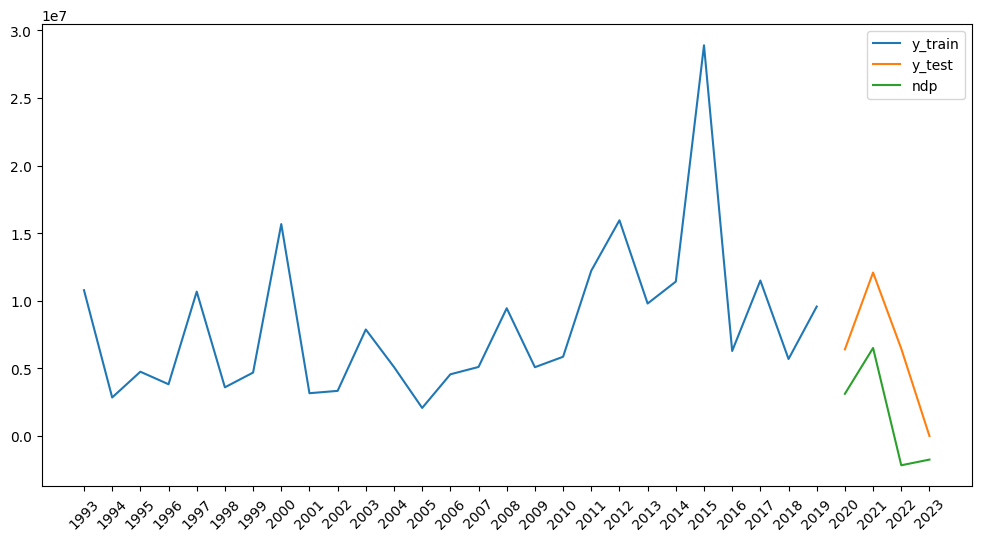

In [49]:
plt.figure(figsize = (12, 6))
plt.plot(y_train, label = 'y_train')
plt.plot(y_test, label = 'y_test')
plt.plot(y_test.index, n3_preds, label = party)
plt.xticks(range(1993, 2024), rotation = 45)
plt.legend();

## Bloc Québécois(B3)

In [50]:
party = 'bloc_québécois'
model_name = 'B3'

#Train test Split 
X_train, y_train, X_test, y_test = get_tts(data = contributions, 
        election_years = election_years, 
       party = party,
       train_end = 2018, 
       test_end = 2023,
       lags = 0)

In [51]:

model_res = pd.concat([model_res, 
                       arima_results(X_train, y_train, X_test, y_test, 
                                     party = party, 
                                     fh = [1,2,3,4], 
                                     model_name = model_name)]
                                    )
b3_preds = extract_preds(model_res, model_name)
model_res.drop(columns = 'preds')

C:\Users\wtlem\anaconda3\envs\sktime_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\wtlem\anaconda3\envs\sktime_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\wtlem\anaconda3\envs\sktime_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\wtlem\anaconda3\envs\sktime_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Va

,model_name,model,party,scaler,rmse,mae
0,L1,lr,liberal,None,5941013.0,3911651.0
0,L2,lr,liberal,log,6547936.0,4090028.0
0,C1,lr,conservative,None,24354536.0,21323675.0
0,C2,lr,conservative,log,29611724.0,24809677.0
0,N1,lr,ndp,None,2885209.0,1795680.0
0,N2,lr,ndp,log,3045706.0,1921515.0
0,B1,lr,bloc_québécois,None,969905.0,894225.0
0,B2,lr,bloc_québécois,log,641509.0,550668.0
0,L3,arima,liberal,None,26531268.0,22931040.0
0,C3,arima,conservative,None,33402313.0,25916453.0


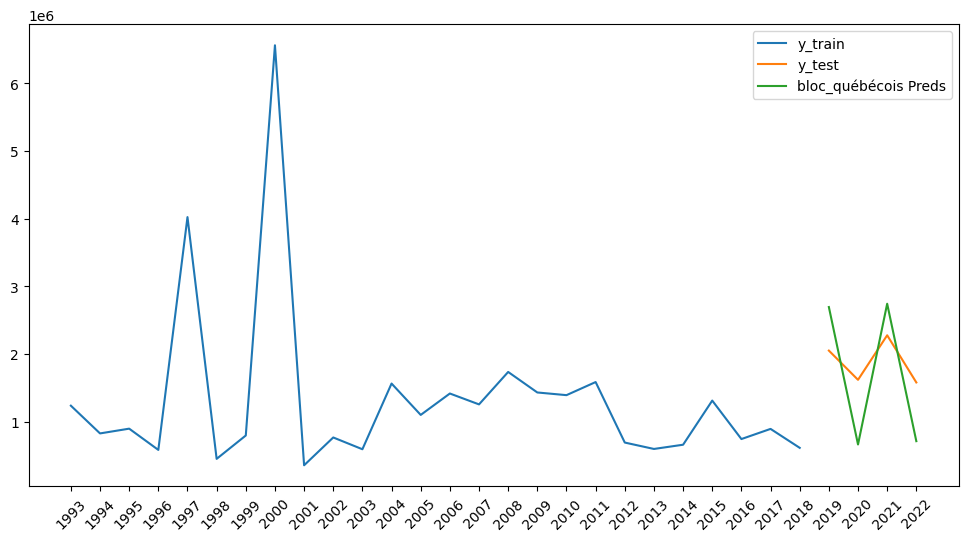

In [52]:
plt.figure(figsize = (12, 6))
plt.plot(y_train, label = 'y_train')
plt.plot(y_test, label = 'y_test')
plt.plot(y_test.index, b3_preds, label = f'{party} Preds')
plt.xticks(range(1993, 2023), rotation = 45)
plt.legend();

In [53]:
print(f'RMSE: {root_mean_squared_error(y_test, preds)}')
print(f'MAE: {mean_absolute_error(y_test, preds)}')

NameError: name 'preds' is not defined

# Compare Models to Baseline

In [ ]:
#create diff columns for later fill
model_res['rmse_diff_base'] = None
model_res['mae_diff_base'] = None 

model_res.loc[model_res['party'] == 'liberal', 'rmse_diff_base'] = liberal_base_rmse - model_res['rmse'].loc[model_res['party'] == 'liberal']
model_res.loc[model_res['party'] == 'conservative','rmse_diff_base'] = conservative_base_rmse - model_res['rmse'].loc[model_res['party'] == 'conservative']
model_res.loc[model_res['party'] == 'ndp','rmse_diff_base'] = ndp_base_rmse - model_res['rmse'].loc[model_res['party'] == 'ndp']
model_res.loc[model_res['party'] == 'bloc_québécois','rmse_diff_base'] = bloc_québécois_base_rmse - model_res['rmse'].loc[model_res['party'] == 'bloc_québécois']

model_res.loc[model_res['party'] == 'liberal', 'mae_diff_base'] = liberal_base_mae - model_res['mae'].loc[model_res['party'] == 'liberal']
model_res.loc[model_res['party'] == 'conservative','mae_diff_base'] = conservative_base_mae - model_res['mae'].loc[model_res['party'] == 'conservative']
model_res.loc[model_res['party'] == 'ndp','mae_diff_base'] = ndp_base_mae - model_res['mae'].loc[model_res['party'] == 'ndp']
model_res.loc[model_res['party'] == 'bloc_québécois','mae_diff_base'] = bloc_québécois_base_mae - model_res['mae'].loc[model_res['party'] == 'bloc_québécois']


In [ ]:
model_res[['party', 'rmse', 'mae']].loc[model_res['party'] == 'bloc_québécois']

In [ ]:
model_res[['model_name','rmse','rmse_diff_base', 'mae', 'mae_diff_base']]

## Model Compare Interpretation

Almost linear models have shown significant improvement over the baseline models, and all Arima models have been shown to be worse than the baseline. The Bloc Québécois is the only party to see no improvement across all models. 